# Introduction
* This notebook contains processing of quotes of several stocks that I downloaded from the site http://firstratedata.com.
* I built features and labels in a recursive matter using historical data. The features and labels engineering is performed by pyspark on an AWS cluster, so the processing is completely parallel, and can process huge data volumes.
* Labels were produced for each stock and for each day, denoting whether the closing price of the next day will be lower or higher than the current day's.
* The goal of the project was to examine whether said labels can be predicted using features based on historical stock quote data, or whether they are too random. 

### The notebook is divided into the following parts:
* [Part 1: Notebook Preparation](#part_1)
* [Part 2: Data Preparation](#part_2)
* [Part 3: Create Labels](#part_3)
* [Part 4: Feature Engineering](#part_4)
* [Part 5: Modeling](#part_5)

### The features I created:
* Max/min/avg/median price over several historic time periods before given quote. 
* Within the same time periods as above, how many days saw the stock increasing or decreasing.
* Time elapsed since last increasing/decreasing day.

### The result:
* The labels indeed seem too random to predict using these features.

<a id='part_1'></a>
# Part 1: Notebook Preparation

## Import

In [1]:
# Data analysis
import pandas as pd
import numpy as np
import time
from datetime import datetime

# Visualization
import seaborn as sns
sns.set(style="white")
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

# Spark
import pyspark.sql.functions as F
import pyspark.sql.types as T

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score,recall_score,precision_score,f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
pd.options.mode.chained_assignment = None  # default='warn'
from IPython.display import Image, display
import pydotplus

%autosave 60

Autosaving every 60 seconds


In [2]:
spark

## Config

In [3]:
dataPath = "Data/symbol=*/*" 
timePeriods = [1,2,3,7,14,30,60,90]

SECONDS_IN_A_DAY = 60*60*24

## Functions

In [4]:
to_int_udf = F.UserDefinedFunction(lambda x: int(x) if x else None, T.IntegerType())
to_float_udf = F.UserDefinedFunction(lambda x: float(x) if x else None, T.DoubleType())

In [5]:
def convert_datetime_to_timestamp(date_time):
    if date_time:
        return int(time.mktime(datetime.strptime(date_time, "%Y.%m.%d %H:%M:%S").timetuple()))
    else:
        return None
    
convert_datetime_to_timestamp_udf = F.UserDefinedFunction(lambda date_time: convert_datetime_to_timestamp(date_time), T.IntegerType())

def median(values_list):
    med = np.median(values_list)
    return float(med)

median_udf = F.UserDefinedFunction(median, T.FloatType())

In [6]:
def plot_model_results(X_test, y_test, fit):

    if hasattr(fit, 'predict_proba'):
        modelScores = fit.predict_proba(X_test)[:,1]
    
    else:
        modelScores = fit.predict(X_test)
    
    # classification_report
    threshold = 0.5
    predBinary = [1 if score > threshold else 0 for score in modelScores]
    
    print(classification_report(y_test, predBinary))
    
    # AUC
    aucScore = roc_auc_score(y_test, modelScores)
    print(f'AUC: {aucScore}')
    
    # Accuracy
    score = fit.score(X_test, y_test)
    print(f'Accuracy: {score}\n')
    
    # confusion_matrix
    print(confusion_matrix(y_test, predBinary, labels=[1,0]))
    
    # Disterbutions
    try:
        trueAndPred = pd.DataFrame(list(zip(y_test, modelScores)), columns=['true', 'pred'])
        trueAndPred[trueAndPred['true'] == 0]['pred'].plot.kde(label='Negative', legend=True)
        trueAndPred[trueAndPred['true'] == 1]['pred'].plot.kde(label='Positive', legend=True)
        fig = plt.gcf()
        fig.set_size_inches(15, 7)
        plt.title('Score distribution')
        plt.show()
    except:
        pass

In [7]:
def plot_feature_importance(X_test, y_test, fit): 

    assert hasattr(fit, 'feature_importances_'), 'No feature importance attribute in the fit'
        
    impDf = pd.DataFrame(list(zip(X_test.columns, fit.feature_importances_)), columns=['feature', 'imp'])\
    .sort_values('imp', ascending=False)

    sns.barplot(x='imp', y='feature', data=impDf.iloc[:25])
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    plt.title('Feature importance')
    plt.show()

In [8]:
def plot_decision_paths(X_test, y_test, fit):
    
    dot_data = tree.export_graphviz(fit, out_file=None, feature_names=X_test.columns,  
                                class_names=[str(label) for label in y_test.unique()], proportion=True)

    # Draw graph
    graph = pydotplus.graph_from_dot_data(dot_data)  

    # Show graph
    display(Image(graph.create_png()))

<a id='part_2'></a>
# Part 2: Data Preparation

In [9]:
df = spark.read.option("basePath", 'Data/').csv(dataPath)\
    .withColumnRenamed('_c0', 'date_time')\
    .withColumnRenamed('_c1', 'open')\
    .withColumnRenamed('_c2', 'high')\
    .withColumnRenamed('_c3', 'low')\
    .withColumnRenamed('_c4', 'close')\
    .withColumnRenamed('_c5', 'volume')\
    .withColumnRenamed('_c6', 'number_of_trades')\
    .withColumnRenamed('_c7', 'weighted_avg_price')\

In [10]:
df = df\
    .withColumn('timestamp', convert_datetime_to_timestamp_udf(F.col('date_time')))\
    .withColumn('day_timestamp', F.UserDefinedFunction(lambda ts: ts-(ts%SECONDS_IN_A_DAY), T.IntegerType())(F.col('timestamp')))\
    .withColumn('open', to_float_udf(F.col('open')))\
    .withColumn('close', to_float_udf(F.col('close')))\
    .withColumn('high', to_float_udf(F.col('high')))\
    .withColumn('low', to_float_udf(F.col('low')))\
    .withColumn('weighted_avg_price', to_float_udf(F.col('weighted_avg_price')))\
    .withColumn('volume', to_int_udf(F.col('volume')))\
    .withColumn('number_of_trades', to_int_udf(F.col('number_of_trades'))).cache()\

In [11]:
df.count()

9770890

In [12]:
df.take(5)

[Row(date_time='2016.10.19 12:09:00', open=32.51, high=32.51, low=32.5, close=32.5, volume=108, number_of_trades=67, weighted_avg_price=32.504, symbol='PFE', timestamp=1476878940, day_timestamp=1476835200),
 Row(date_time='2016.10.19 12:10:00', open=32.51, high=32.51, low=32.51, close=32.5, volume=213, number_of_trades=71, weighted_avg_price=32.507, symbol='PFE', timestamp=1476879000, day_timestamp=1476835200),
 Row(date_time='2016.10.19 12:11:00', open=32.51, high=32.51, low=32.51, close=32.5, volume=180, number_of_trades=84, weighted_avg_price=32.503, symbol='PFE', timestamp=1476879060, day_timestamp=1476835200),
 Row(date_time='2016.10.19 12:12:00', open=32.5, high=32.51, low=32.51, close=32.5, volume=127, number_of_trades=66, weighted_avg_price=32.505, symbol='PFE', timestamp=1476879120, day_timestamp=1476835200),
 Row(date_time='2016.10.19 12:13:00', open=32.5, high=32.51, low=32.5, close=32.5, volume=108, number_of_trades=66, weighted_avg_price=32.503, symbol='PFE', timestamp=147

<a id='part_3'></a>
# Part 3: Create Labels

In [14]:
# get max ts per symbol and day
maxTsPerSymbolAndDay = df\
    .groupby(F.col('symbol'), F.col('day_timestamp'))\
    .agg(F.max(F.col('timestamp')).alias('timestamp'))

filteredOnMaxTsPerDay = df\
    .join(maxTsPerSymbolAndDay, ['symbol', 'day_timestamp', 'timestamp'], 'inner')\
    .withColumn('previous_day_ts', F.UserDefinedFunction(lambda ts: ts-SECONDS_IN_A_DAY, T.IntegerType())(F.col('day_timestamp')))

In [15]:
# get the previous day closing price
dfWithLabels = filteredOnMaxTsPerDay\
    .join(filteredOnMaxTsPerDay.select(F.col('symbol'), 
          F.col('day_timestamp').alias('previous_day_ts'), 
          F.col('close').alias('previous_close')), ['symbol', 'previous_day_ts'], 'inner')\
    .withColumn('label', \
                F.UserDefinedFunction(lambda close_today, close_yesterday: int(close_today>close_yesterday),\
                                      T.IntegerType())(F.col('close'), F.col('previous_close')))\
    .select(F.col('symbol'), F.col('day_timestamp'), F.col('label'), F.col('close').alias('next_close_price')).cache()

In [16]:
dfWithLabels.take(5)

[Row(symbol='AAPL', day_timestamp=1089244800, label=0, next_close_price=4.29),
 Row(symbol='AAPL', day_timestamp=1091145600, label=0, next_close_price=4.62),
 Row(symbol='AAPL', day_timestamp=1093305600, label=1, next_close_price=4.55),
 Row(symbol='AAPL', day_timestamp=1131580800, label=1, next_close_price=8.73),
 Row(symbol='AAPL', day_timestamp=1177459200, label=1, next_close_price=13.61)]

* As can be seen in the table below, the data is balanced between days which the share price rose relative to the day before (label=1), and days when the share price fell relative to the day before (label=0).

In [17]:
dfWithLabels\
.groupby(F.col('label'))\
.agg(F.count(F.col('symbol'))).show()

+-----+-------------+
|label|count(symbol)|
+-----+-------------+
|    1|        10075|
|    0|         9558|
+-----+-------------+



<a id='part_4'></a>
# Part 4: Feature Engineering

* In the feature engineering I check the starting time of each stock so that featureswould be calculated on a time period (for example 90 days) only if the entire time period is contained in the data (there is data 90 days back).
* I assume there is data continuously from start to end.

In [18]:
minTsPerSymbol = df\
    .groupby(F.col('symbol'))\
    .agg(F.min(F.col('timestamp')).alias('min_ts_per_symbol')).cache()

In [20]:
minTsPerSymbol.show()

+------+-----------------+
|symbol|min_ts_per_symbol|
+------+-----------------+
|  AAPL|       1074850200|
|  CSCO|       1074850200|
|     T|       1133429400|
|   PFE|       1074850200|
|   AEP|       1074850260|
|    MA|       1148551380|
|  AMZN|       1074850200|
+------+-----------------+



### Max/min/avg/median price over several historic time periods before given quote. 


In [21]:
groupbyDay = df\
    .groupby(F.col('symbol'), F.col('day_timestamp'))\
    .agg(F.max(F.col('high')).alias(f'max_price'),\
         F.min(F.col('low')).alias(f'min_price'),\
         F.avg(F.col('weighted_avg_price')).alias(f'avg_price'),\
         median_udf(F.collect_list(F.col('weighted_avg_price'))).alias(f'median_price'),\
         F.sum(F.col('volume')).alias(f'sum_volume'),\
         F.sum(F.col('number_of_trades')).alias(f'sum_num_of_trades'))\
    .cache()

In [22]:
timePeriodsDf = spark.createDataFrame(pd.DataFrame({'timePeriod': timePeriods}))

In [23]:
generalFeatures = groupbyDay\
    .join(minTsPerSymbol, 'symbol', 'inner').alias('a')\
    .crossJoin(timePeriodsDf)\
    .where((F.col('day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY)) >= F.col('min_ts_per_symbol'))\
    .join(groupbyDay.alias('b'), 'symbol', 'inner')\
    .where((F.col('a.day_timestamp') < F.col('b.day_timestamp')) & \
           (F.col('a.day_timestamp') >= (F.col('b.day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY))))\
    .groupby(F.col('symbol'), F.col('b.day_timestamp'), F.col('timePeriod'))\
    .agg(F.max(F.col('a.max_price')).alias(f'max_price'),\
         F.min(F.col('a.min_price')).alias(f'min_price'),\
         F.avg(F.col('a.avg_price')).alias(f'avg_price'),\
         median_udf(F.collect_list(F.col('a.median_price'))).alias(f'median_price'),\
         F.sum(F.col('a.sum_volume')).alias(f'sum_volume'),\
         F.sum(F.col('a.sum_num_of_trades')).alias(f'sum_num_of_trades'))\
    .cache()

dfWithLabelsAndFeatures_1 = dfWithLabels.cache()

for timePeriod in timePeriods:
    
    filteredByTimePeriod_temp = generalFeatures\
        .where(F.col('timePeriod') == timePeriod)\
        .withColumnRenamed('max_price', f'max_price_{timePeriod}_days')\
        .withColumnRenamed('min_price', f'min_price_{timePeriod}_days')\
        .withColumnRenamed('avg_price', f'avg_price_{timePeriod}_days')\
        .withColumnRenamed('median_price', f'median_price_{timePeriod}_days')\
        .withColumnRenamed('sum_volume', f'sum_volume_{timePeriod}_days')\
        .withColumnRenamed('sum_num_of_trades', f'sum_num_of_trades_{timePeriod}_days')\
        .drop(F.col('timePeriod')).cache()

    dfWithLabelsAndFeatures_1 = dfWithLabelsAndFeatures_1\
        .join(filteredByTimePeriod_temp, ['symbol', 'day_timestamp'], 'left').cache()

### Within the same time periods as above, how many days saw the stock increasing or decreasing.

In [24]:
previousLabelsFeatures = dfWithLabels\
    .join(minTsPerSymbol, 'symbol', 'inner').alias('a')\
    .crossJoin(timePeriodsDf)\
    .where((F.col('day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY)) >= F.col('min_ts_per_symbol'))\
    .join(dfWithLabels.select(F.col('symbol'), F.col('day_timestamp').alias('previous_days_ts'), 
                              F.col('label').alias('previous_labels')).alias('b'), 'symbol', 'inner')\
    .where((F.col('b.previous_days_ts') < F.col('a.day_timestamp')) & \
           (F.col('b.previous_days_ts') >= (F.col('a.day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY))))\
    .groupby(F.col('symbol'), F.col('a.day_timestamp'), F.col('timePeriod'))\
    .agg(F.avg(F.col('b.previous_labels')).alias(f'avg_previous_labels'),\
         F.sum(F.col('b.previous_labels')).alias(f'sum_previous_labels'))\
    .cache()

In [25]:
dfWithLabelsAndFeatures_2 = dfWithLabels.select(F.col('symbol'), F.col('day_timestamp')).cache()

for timePeriod in timePeriods:
    
    filteredByTimePeriod_temp = previousLabelsFeatures\
        .where(F.col('timePeriod') == timePeriod)\
        .withColumnRenamed('avg_previous_labels', f'avg_previous_labels_{timePeriod}_days')\
        .withColumnRenamed('sum_previous_labels', f'sum_previous_labels_{timePeriod}_days')\
        .drop(F.col('timePeriod'))\
        .withColumnRenamed('symbol', 'symbol2')\
        .withColumnRenamed('day_timestamp', 'day_timestamp2')\
        .cache()

    dfWithLabelsAndFeatures_2 = dfWithLabelsAndFeatures_2\
        .join(filteredByTimePeriod_temp, 
              ((dfWithLabelsAndFeatures_2.symbol == filteredByTimePeriod_temp.symbol2) &\
               (dfWithLabelsAndFeatures_2.day_timestamp == filteredByTimePeriod_temp.day_timestamp2)), 'left')\
        .drop('symbol2','day_timestamp2').cache()
    
dfWithLabelsAndFeatures_2 = dfWithLabelsAndFeatures_2\
    .withColumnRenamed('symbol', 'symbol2')\
    .withColumnRenamed('day_timestamp', 'day_timestamp2')\

### Time elapsed since last increasing/decreasing day.

In [26]:
onlyUps = dfWithLabels\
    .join(minTsPerSymbol, 'symbol', 'inner').alias('a')\
    .crossJoin(timePeriodsDf)\
    .where((F.col('day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY)) >= F.col('min_ts_per_symbol'))\
    .join(dfWithLabels.select(F.col('symbol').alias('symbol3'), 
                                           F.col('day_timestamp').alias('previous_days_ts'), 
                                           F.col('label').alias('previous_labels')).alias('b'),\
          (F.col('a.symbol') == F.col('b.symbol3')), 'inner')\
    .where((F.col('b.previous_days_ts') < F.col('a.day_timestamp')) &\
           (F.col('b.previous_days_ts') >= (F.col('a.day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY))))\
    .drop('symbol3')\
    .where(F.col('previous_labels') == 1)\
    .groupby(F.col('symbol').alias('symbol3'), F.col('day_timestamp').alias('day_timestamp3'), F.col('timePeriod'))\
    .agg(F.max(F.col('previous_days_ts')).alias(f'max_ts_of_previous_increase'),\
         F.min(F.col('previous_days_ts')).alias(f'min_ts_of_previous_increase'))\
    .withColumn(f'days_since_max_previous_increase',\
                F.UserDefinedFunction(lambda x,y: int((x-y)/SECONDS_IN_A_DAY), T.IntegerType())\
                (F.col('day_timestamp3'), F.col(f'max_ts_of_previous_increase')))\
    .withColumn(f'days_since_min_previous_increase',\
                F.UserDefinedFunction(lambda x,y: int((x-y)/SECONDS_IN_A_DAY), T.IntegerType())\
                (F.col('day_timestamp3'), F.col(f'min_ts_of_previous_increase')))\
    .cache()

onlyDowns = dfWithLabels\
    .join(minTsPerSymbol, 'symbol', 'inner').alias('a')\
    .crossJoin(timePeriodsDf)\
    .where((F.col('day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY)) >= F.col('min_ts_per_symbol'))\
    .join(dfWithLabels.select(F.col('symbol').alias('symbol3'), 
                                           F.col('day_timestamp').alias('previous_days_ts'), 
                                           F.col('label').alias('previous_labels')).alias('b'),\
          (F.col('a.symbol') == F.col('b.symbol3')), 'inner')\
    .where((F.col('b.previous_days_ts') < F.col('a.day_timestamp')) &\
           (F.col('b.previous_days_ts') >= (F.col('a.day_timestamp') - (F.col('timePeriod')*SECONDS_IN_A_DAY))))\
    .drop('symbol3')\
    .where(F.col('previous_labels') == 0)\
    .groupby(F.col('symbol').alias('symbol4'), F.col('day_timestamp').alias('day_timestamp4'), F.col('timePeriod'))\
    .agg(F.max(F.col('previous_days_ts')).alias(f'max_ts_of_previous_decrease'),\
         F.min(F.col('previous_days_ts')).alias(f'min_ts_of_previous_decrease'))\
    .withColumn(f'days_since_max_previous_decrease',\
                F.UserDefinedFunction(lambda x,y: int((x-y)/SECONDS_IN_A_DAY), T.IntegerType())\
                (F.col('day_timestamp4'), F.col(f'max_ts_of_previous_decrease')))\
    .withColumn(f'days_since_min_previous_decrease',\
                F.UserDefinedFunction(lambda x,y: int((x-y)/SECONDS_IN_A_DAY), T.IntegerType())\
                (F.col('day_timestamp4'), F.col(f'min_ts_of_previous_decrease')))\
    .cache()

In [27]:
dfWithLabelsAndFeatures_3 = dfWithLabels.select(F.col('symbol'), F.col('day_timestamp')).cache()

for timePeriod in timePeriods:
    
    filteredByTimePeriodOnlyUps_temp = onlyUps\
        .where(F.col('timePeriod') == timePeriod)\
        .withColumnRenamed('max_ts_of_previous_increase', f'max_ts_of_previous_increase_{timePeriod}_days')\
        .withColumnRenamed('min_ts_of_previous_increase', f'min_ts_of_previous_increase_{timePeriod}_days')\
        .withColumnRenamed('days_since_max_previous_increase', f'days_since_max_previous_increase_{timePeriod}_days')\
        .withColumnRenamed('days_since_min_previous_increase', f'days_since_min_previous_increase_{timePeriod}_days')\
        .drop(F.col('timePeriod'))\
        .cache()
    
    filteredByTimePeriodOnlyDowns_temp = onlyDowns\
        .where(F.col('timePeriod') == timePeriod)\
        .withColumnRenamed('max_ts_of_previous_decrease', f'max_ts_of_previous_decrease_{timePeriod}_days')\
        .withColumnRenamed('min_ts_of_previous_decrease', f'min_ts_of_previous_decrease_{timePeriod}_days')\
        .withColumnRenamed('days_since_max_previous_decrease', f'days_since_max_previous_decrease_{timePeriod}_days')\
        .withColumnRenamed('days_since_min_previous_decrease', f'days_since_min_previous_decrease_{timePeriod}_days')\
        .drop(F.col('timePeriod'))\
        .cache()

    dfWithLabelsAndFeatures_3 = dfWithLabelsAndFeatures_3\
        .join(filteredByTimePeriodOnlyUps_temp, 
              ((dfWithLabelsAndFeatures_3.symbol == filteredByTimePeriodOnlyUps_temp.symbol3) &\
               (dfWithLabelsAndFeatures_3.day_timestamp == filteredByTimePeriodOnlyUps_temp.day_timestamp3)), 'left')\
        .join(filteredByTimePeriodOnlyDowns_temp, 
              ((dfWithLabelsAndFeatures_3.symbol == filteredByTimePeriodOnlyDowns_temp.symbol4) &\
               (dfWithLabelsAndFeatures_3.day_timestamp == filteredByTimePeriodOnlyDowns_temp.day_timestamp4)), 'left')\
        .drop('symbol3','day_timestamp3','symbol4','day_timestamp4').cache()
    
dfWithLabelsAndFeatures_3 = dfWithLabelsAndFeatures_3\
    .withColumnRenamed('symbol', 'symbol3')\
    .withColumnRenamed('day_timestamp', 'day_timestamp3')\

## Merge all features together to a single dataframe and convert to pandas.

In [28]:
mergedDf = dfWithLabelsAndFeatures_1\
    .join(dfWithLabelsAndFeatures_2, 
          ((dfWithLabelsAndFeatures_1.symbol == dfWithLabelsAndFeatures_2.symbol2) &\
           (dfWithLabelsAndFeatures_1.day_timestamp == dfWithLabelsAndFeatures_2.day_timestamp2)), 'inner')\
    .join(dfWithLabelsAndFeatures_3, 
          ((dfWithLabelsAndFeatures_1.symbol == dfWithLabelsAndFeatures_3.symbol3) &\
           (dfWithLabelsAndFeatures_1.day_timestamp == dfWithLabelsAndFeatures_3.day_timestamp3)), 'inner')\
    .drop('symbol2', 'day_timestamp2', 'symbol3', 'day_timestamp3').cache()

In [29]:
mergedDf.take(1)

[Row(symbol='AAPL', day_timestamp=1089158400, label=0, next_close_price=4.32, max_price_1_days=4.49, min_price_1_days=4.4, avg_price_1_days=4.444525274512823, median_price_1_days=4.4435715675354, sum_volume_1_days=397509, sum_num_of_trades_1_days=19127, max_price_2_days=4.49, min_price_2_days=4.4, avg_price_2_days=4.444525274512823, median_price_2_days=4.4435715675354, sum_volume_2_days=397509, sum_num_of_trades_2_days=19127, max_price_3_days=4.49, min_price_3_days=4.4, avg_price_3_days=4.444525274512823, median_price_3_days=4.4435715675354, sum_volume_3_days=397509, sum_num_of_trades_3_days=19127, max_price_7_days=4.49, min_price_7_days=4.4, avg_price_7_days=4.444525274512823, median_price_7_days=4.4435715675354, sum_volume_7_days=397509, sum_num_of_trades_7_days=19127, max_price_14_days=4.88, min_price_14_days=4.4, avg_price_14_days=4.666308791072652, median_price_14_days=4.724964141845703, sum_volume_14_days=2791089, sum_num_of_trades_14_days=116413, max_price_30_days=4.88, min_pric

In [30]:
mergedDf.count()

19633

In [31]:
mergedDf_pandas = mergedDf.toPandas()

In [32]:
mergedDf_pandas.head(5)

,symbol,day_timestamp,label,next_close_price,max_price_1_days,min_price_1_days,avg_price_1_days,median_price_1_days,sum_volume_1_days,sum_num_of_trades_1_days,...,days_since_max_previous_decrease_60_days,days_since_min_previous_decrease_60_days,max_ts_of_previous_increase_90_days,min_ts_of_previous_increase_90_days,days_since_max_previous_increase_90_days,days_since_min_previous_increase_90_days,max_ts_of_previous_decrease_90_days,min_ts_of_previous_decrease_90_days,days_since_max_previous_decrease_90_days,days_since_min_previous_decrease_90_days
0,AAPL,1089158400,0,4.32,4.49,4.40,4.444525,4.443572,397509.0,19127.0,...,13.0,55.0,1.088467e+09,1.081382e+09,8.0,90.0,1.088035e+09,1.081814e+09,13.0,85.0
1,AAPL,1091059200,1,4.66,4.63,4.45,4.540631,4.539571,338051.0,17688.0,...,1.0,56.0,1.090886e+09,1.083629e+09,2.0,86.0,1.090973e+09,1.083283e+09,1.0,90.0
2,AAPL,1131494400,1,8.58,8.63,8.46,8.536576,8.545000,1144227.0,73171.0,...,1.0,57.0,1.130976e+09,1.123718e+09,6.0,90.0,1.131408e+09,1.124150e+09,1.0,85.0
3,AAPL,1177372800,0,13.32,13.40,13.07,13.278973,13.290643,1804852.0,113266.0,...,5.0,60.0,1.177027e+09,1.169597e+09,4.0,90.0,1.176941e+09,1.169683e+09,5.0,89.0
4,AAPL,1203638400,0,16.99,18.07,17.28,17.557547,17.518215,2190986.0,172293.0,...,1.0,57.0,1.203466e+09,1.196122e+09,2.0,87.0,1.203552e+09,1.196381e+09,1.0,84.0


<a id='part_5'></a>
# Part 5: Modeling
* As can be seen in the model results, these features don't seem enough to predict these kind of labels, which are probably too random.

In [33]:
CLASS_LABEL = 'label'

featureNames = ['max_price', 'min_price', 'avg_price', 'median_price', 'sum_volume', 'sum_num_of_trades', 
'sum_previous_labels', 'avg_previous_labels',
'days_since_max_previous_increase', 'days_since_min_previous_increase', 
'days_since_max_previous_decrease', 'days_since_min_previous_decrease']

featuresList = [f'{featureName}_{timePeriod}_days' for featureName in featureNames for timePeriod in timePeriods]

In [34]:
X = mergedDf_pandas[~pd.isna(mergedDf_pandas[CLASS_LABEL])]
if CLASS_LABEL in X.columns:
    X = X.drop(CLASS_LABEL, 1)
y = mergedDf_pandas[CLASS_LABEL][~pd.isna(mergedDf_pandas[CLASS_LABEL])]

In [35]:
# Leave only the relevant features
featuresToSelect = featuresList
X = X[featuresToSelect]
X = X.fillna(X.mean())

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [37]:
mod = DecisionTreeClassifier(max_depth=5, criterion='entropy', min_samples_leaf=int(len(X_train)*0.1))
fit = mod.fit(X_train, y_train)

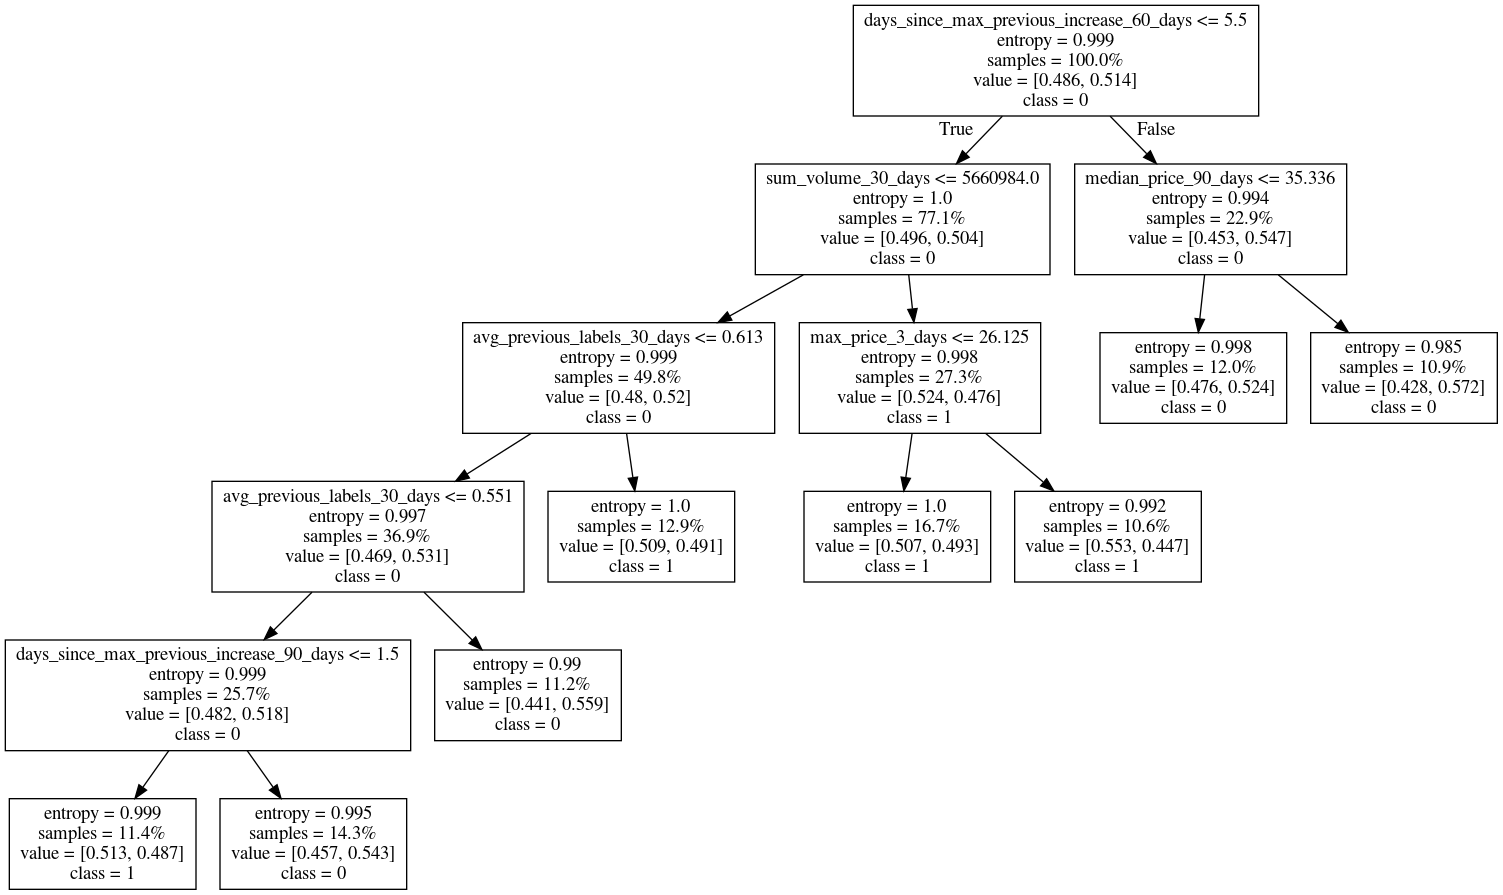

In [38]:
plot_decision_paths(X_test, y_test, fit)

              precision    recall  f1-score   support

           0       0.49      0.51      0.50      3167
           1       0.52      0.50      0.51      3312

    accuracy                           0.51      6479
   macro avg       0.51      0.51      0.51      6479
weighted avg       0.51      0.51      0.51      6479

AUC: 0.5058557432550961
Accuracy: 0.5056335854298503

[[1649 1663]
 [1540 1627]]


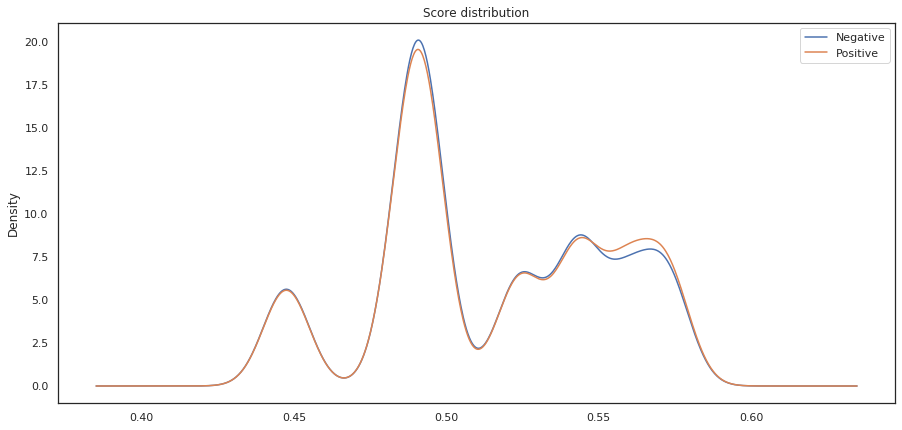

In [39]:
plot_model_results(X_test, y_test, fit)

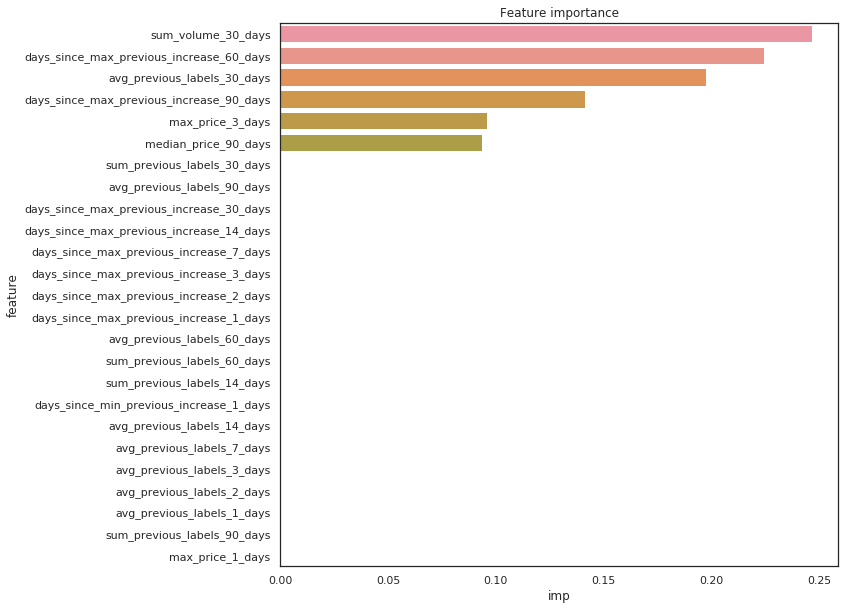

In [40]:
plot_feature_importance(X_train, y_train, fit)